In [1]:
import random as ran
import numpy as np
import pandas as pd

# for displaying images not necessary for function
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def game(config, episodes=500000):
    # Creating the variables which will hold all the important values of the algorithm
    rewards, wins, losses, draws = 0, 0, 0, 0
    winsCounter, lossesCounter, drawsCounter, episodeCounter = [], [], [], []
    # Creating all the tables
    actions, table, Q_Values= state_action_table()
    QCounter = state_action_table() [2]
    policy_table = {}

    # Policy table which holds the boolean for if the player should hit at a specific state-action
    for i in table.keys():
        policy_table[i] = True

    # The Monte Carlo Algorithm starts here
    for i in range(episodes):
        if (i % 1000) == 0:
            # Every thousand episodes, the wins, losses and draws are outputted and reset
            print("Wins: ", wins, " Losses: ", losses, " Draws: ", draws)
            winsCounter.append(wins)
            lossesCounter.append(losses)
            drawsCounter.append(draws)
            episodeCounter.append(i)
            wins, losses, draws = 0, 0, 0

        current_state = -1
        # Creating the environment
        player_cards, dealer_cards, Card_Deck = environ()
        # Creating a list to hold all the state-actions
        state_actions = []

        ace = total(player_cards)[1]

        current_state += 1

        # Making sure that the player has between 12 and 20 before the AI takes over
        while True:
            if 12 <= total(player_cards)[0] < 21:
                break
            elif total(player_cards)[0] == 21:
                break
            else:
                player_cards.append(Card_Deck.pop(ran.randint(0, len(Card_Deck) - 1)))
                if ace == 1:
                    continue
                else:
                    ace = total(player_cards)[1]
                    continue
        
        if total(player_cards)[0] == 21:
            wins += 1
            continue
            
        # Adding the current state to the list
        state_actions.append((total(player_cards)[0], total(dealer_cards)[0], ace))
       

        while True:
            # If the first state hits, the algorithm will check for a usable ace to update the state-actions list
            if current_state > 0:
                ace = total(player_cards)[1]
                state_actions.append((total(player_cards)[0], total(dealer_cards)[0], ace))             

            e = 0
            exp = 2.718

            # Calculating the epsilon value depending on the configuration
            if config == 1 or config == 2:
                e =  1/(i+1)
            elif config == 3:
                e = pow(exp, (-i / 1000))
            elif config == 4:
                e = pow(exp, (-i / 10000))

            # Calculating which is the better action to perform at this state
            a = epsilon(Q_Values, e, state_actions[current_state], [0, 1], current_state, config)
            QCounter[state_actions[current_state]][a] += 1

            if a == 1:
                # Hitting for a new card
                new_card = Card_Deck.pop(ran.randint(0, len(Card_Deck) - 1))
                player_cards.append(new_card)

                # Player Loses
                if total(player_cards)[0] > 21:
                    losses += 1
                    rewards -= 1
                    # Policy is updated and improved
                    policy(Q_Values, policy_table, table, state_actions, -1, a)
                    break
                # Next action is calculated because the player has not lost
                elif 12 < total(player_cards)[0] < 20:
                    current_state += 1
                    continue

            elif a == 0:
                # Dealer hits to try to win against the player
                dealer(dealer_cards, Card_Deck)

                # Dealer passes 21 and player wins
                if total(dealer_cards)[0] > 21:
                    wins += 1
                    rewards += 1
                    # Policy is updated
                    policy(Q_Values, policy_table, table, state_actions, 1, a)
                    break
                else:
                    # Dealer has a higher value than player and player loses
                    if total(dealer_cards)[0] > total(player_cards)[0]:
                        losses += 1
                        rewards -= 1
                        # Policy is updated and improved
                        policy(Q_Values, policy_table, table, state_actions, -1, a)
                        break
                    # Player has higher value than dealer and player wins
                    elif total(dealer_cards)[0] < total(player_cards)[0]:
                        wins += 1
                        rewards += 1
                        # Policy is updated
                        policy(Q_Values, policy_table, table, state_actions, 1, a)
                        break
                    # Player and Dealer Values are Draw
                    else:
                        draws += 1
                        rewards += 0
                        # Policy is updated
                        policy(Q_Values, policy_table, table, state_actions, 0, a)
                        break
    return winsCounter, lossesCounter, drawsCounter, episodeCounter, QCounter, Q_Values


In [3]:
# Finding the total value of all the cards in a hand
def total(cards):
    sum_cards = 0
    A_s = 0
    AceFlag = 0

    for card in cards:
        if card == 'J' or card == 'Q' or card == 'K':
            sum_cards += 10
        elif card == 'A':
            A_s += 1
            sum_cards += 1
        else:
            sum_cards += card

# Checking for a usable_Ace
    for x in range(A_s):
        if (sum_cards + 10) <= 21:
            sum_cards += 10
            AceFlag = 1
            break

    return sum_cards, AceFlag

In [4]:
# Creating the environment for every new episode
def environ():
    deck = ['A', 'A', 'A', 'A', 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8,
            9,
            9, 9, 9, 10, 10, 10, 10, 'J', 'J', 'J', 'J', 'Q', 'Q', 'Q', 'Q', 'K', 'K', 'K', 'K']

    dealer_cards = list()
    player_cards = list()

    player_cards.append(deck.pop(ran.randint(0, len(deck) - 1)))
    player_cards.append(deck.pop(ran.randint(0, len(deck) - 1)))
    dealer_cards.append(deck.pop(ran.randint(0, len(deck) - 1)))

    return player_cards, dealer_cards, deck

In [5]:
# Hitting for a new card till the dealer's value is above 17
def dealer(score, cards):
    while True:
        if total(score)[0] < 17:
            score.append(cards.pop(ran.randint(0, len(cards) - 1)))
        else:
            break

In [6]:
def state_action_table():
    actions = [1, 0]
    QTable = {}
    table = {}

    # Creating the Q_Values and the Frequency Table Dictionaries

    for playerHand in range(12, 22):  # Player sum [12..21]
        for dealerHand in range(2, 12):  # Card dealer [2..11]
            for ace in [1, 0]:  # Has card / Doesn't
                QTable[(playerHand, dealerHand, ace)] = {}
                table[(playerHand, dealerHand, ace)] = {}
                for action in actions:  # Initialise value to 0
                    QTable[(playerHand, dealerHand, ace)][action] = 0  # Set all values to 0
                    table[(playerHand, dealerHand, ace)][action] = 0
    return actions, table, QTable


In [7]:
def epsilon(Q_Values, e, state, act, current_state, config):
    action = 0

    # Returning to stand since the value is 21
    if state[0] == 21:
        return 0

    # Exploring Starts First State of each episode
    if current_state == 0 and config == 1:
        action = np.random.choice(act)

    # Random or Greedy Action chosen
    else:
        if np.random.random() >= e:
            value = -9999
            for a in Q_Values[state]:
                if Q_Values[state][a] > value:
                    action = a
                    value = Q_Values[state][a]
        else:
            action = np.random.choice(act)

    return action

In [8]:
# Evaluating and Improving the policy
def policy(Q_Values, policy_table, table, state_actions, reward_action, action):
    for state in state_actions:
        # Increasing the frequency of the state-action
        table[state][action] += 1

        # Updating the Q_Value of the specific state_action
        Q_Values[state][action] += (0.1 * (reward_action - Q_Values[state][action])) / table[state][action]

        # Updating the policy
        if Q_Values[state][0] > Q_Values[state][1]:
            policy_table[state] = True
        else:
            policy_table[state] = False

    return Q_Values, policy_table, table, state_actions


Prints Main Menu and lets the user choose the policy

In [9]:
ep = 500000
# Menu to choose Monte Carlo Variant
print("Monte Carlo BlackJack Algorithm Menu")
print("First, choose a Variant: (1) Exploring Starts (Default) No Exploring Starts")
choice = int(input())

if choice == 1:
    wins_line_plot,losses_line_plot,draw_line_plot,episodes_line_plot,SACounter,table_policy = game(1, ep)
else:
    while True:
        # Menu to choose configuration
        print("Choose a configuration: (1) Ɛ = 1/k (2) Ɛ = e^(-k/1000) (3) Ɛ = e^(-k/10000)")
        choice = int(input())
        if choice == 1:
            wins_line_plot,losses_line_plot,draw_line_plot,episodes_line_plot,SACounter,table_policy = game(2, ep)
            break
        elif choice == 2:
            wins_line_plot,losses_line_plot,draw_line_plot,episodes_line_plot,SACounter,table_policy = game(3, ep)
            break
        elif choice == 3:
            wins_line_plot,losses_line_plot,draw_line_plot,episodes_line_plot,SACounter,table_policy = game(4, ep)
            break
        else:
            print("Incorrect Value, try again")

Monte Carlo BlackJack Algorithm Menu
First, choose a Variant: (1) Exploring Starts (Default) No Exploring Starts
1
Wins:  0  Losses:  0  Draws:  0
Wins:  333  Losses:  626  Draws:  41
Wins:  345  Losses:  597  Draws:  58
Wins:  335  Losses:  626  Draws:  39
Wins:  311  Losses:  651  Draws:  38
Wins:  315  Losses:  636  Draws:  49
Wins:  345  Losses:  610  Draws:  45
Wins:  340  Losses:  620  Draws:  40
Wins:  303  Losses:  646  Draws:  51
Wins:  316  Losses:  640  Draws:  44
Wins:  334  Losses:  611  Draws:  55
Wins:  320  Losses:  632  Draws:  48
Wins:  304  Losses:  629  Draws:  67
Wins:  344  Losses:  623  Draws:  33
Wins:  353  Losses:  580  Draws:  67
Wins:  326  Losses:  624  Draws:  50
Wins:  327  Losses:  629  Draws:  44
Wins:  355  Losses:  602  Draws:  43
Wins:  351  Losses:  605  Draws:  44
Wins:  352  Losses:  600  Draws:  48
Wins:  350  Losses:  610  Draws:  40
Wins:  325  Losses:  624  Draws:  51
Wins:  342  Losses:  614  Draws:  44
Wins:  330  Losses:  612  Draws:  58
Wi

Wins:  340  Losses:  615  Draws:  45
Wins:  331  Losses:  633  Draws:  36
Wins:  337  Losses:  628  Draws:  35
Wins:  304  Losses:  651  Draws:  45
Wins:  333  Losses:  626  Draws:  41
Wins:  327  Losses:  626  Draws:  47
Wins:  316  Losses:  621  Draws:  63
Wins:  334  Losses:  619  Draws:  47
Wins:  332  Losses:  622  Draws:  46
Wins:  372  Losses:  592  Draws:  36
Wins:  344  Losses:  615  Draws:  41
Wins:  323  Losses:  636  Draws:  41
Wins:  313  Losses:  640  Draws:  47
Wins:  335  Losses:  631  Draws:  34
Wins:  324  Losses:  631  Draws:  45
Wins:  355  Losses:  608  Draws:  37
Wins:  308  Losses:  638  Draws:  54
Wins:  336  Losses:  628  Draws:  36
Wins:  329  Losses:  625  Draws:  46
Wins:  348  Losses:  609  Draws:  43
Wins:  326  Losses:  624  Draws:  50
Wins:  320  Losses:  629  Draws:  51
Wins:  344  Losses:  606  Draws:  50
Wins:  323  Losses:  628  Draws:  49
Wins:  334  Losses:  616  Draws:  50
Wins:  334  Losses:  619  Draws:  47
Wins:  317  Losses:  633  Draws:  50
W

Wins:  329  Losses:  629  Draws:  42
Wins:  336  Losses:  622  Draws:  42
Wins:  339  Losses:  615  Draws:  46
Wins:  324  Losses:  627  Draws:  49
Wins:  323  Losses:  639  Draws:  38
Wins:  310  Losses:  643  Draws:  47
Wins:  332  Losses:  620  Draws:  48
Wins:  330  Losses:  628  Draws:  42
Wins:  324  Losses:  639  Draws:  37
Wins:  332  Losses:  621  Draws:  47
Wins:  355  Losses:  597  Draws:  48
Wins:  312  Losses:  632  Draws:  56
Wins:  350  Losses:  615  Draws:  35
Wins:  345  Losses:  613  Draws:  42
Wins:  332  Losses:  630  Draws:  38
Wins:  340  Losses:  626  Draws:  34
Wins:  327  Losses:  629  Draws:  44
Wins:  330  Losses:  623  Draws:  47
Wins:  334  Losses:  621  Draws:  45
Wins:  332  Losses:  617  Draws:  51
Wins:  326  Losses:  635  Draws:  39
Wins:  326  Losses:  633  Draws:  41
Wins:  334  Losses:  616  Draws:  50
Wins:  313  Losses:  640  Draws:  47
Wins:  339  Losses:  611  Draws:  50
Wins:  350  Losses:  595  Draws:  55
Wins:  366  Losses:  595  Draws:  39
W

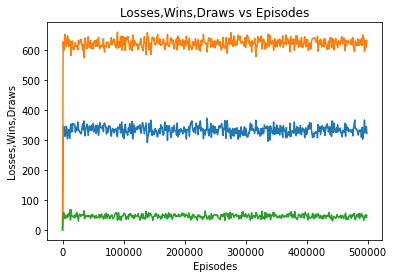

In [10]:
plt.plot(episodes_line_plot, wins_line_plot)
plt.plot(episodes_line_plot, losses_line_plot)
plt.plot(episodes_line_plot, draw_line_plot)
plt.title('Losses,Wins,Draws vs Episodes')
plt.xlabel('Episodes')
plt.ylabel('Losses,Wins,Draws')
plt.show()

['(15, 10, 0) Hit', '(17, 10, 0) Hit', '(13, 10, 0) Hit', '(16, 10, 0) Hit', '(14, 10, 0) Hit', '(19, 10, 0) Hit', '(18, 10, 0) Hit', '(12, 10, 0) Hit', '(12, 10, 0) Stand', '(13, 10, 0) Stand', '(20, 10, 0) Stand', '(20, 10, 0) Hit', '(14, 10, 0) Stand', '(15, 10, 0) Stand', '(16, 10, 0) Stand', '(17, 10, 0) Stand', '(18, 10, 0) Stand', '(19, 10, 0) Stand', '(17, 11, 0) Hit', '(16, 11, 0) Hit', '(17, 9, 0) Hit', '(15, 8, 0) Hit', '(17, 8, 0) Hit', '(17, 6, 0) Hit', '(17, 2, 0) Hit', '(18, 4, 0) Hit', '(15, 11, 0) Hit', '(16, 7, 0) Hit', '(19, 7, 0) Hit', '(15, 9, 0) Hit', '(16, 9, 0) Hit', '(16, 3, 0) Hit', '(17, 3, 0) Hit', '(19, 8, 0) Hit', '(15, 3, 0) Hit', '(16, 2, 0) Hit', '(14, 3, 0) Hit', '(18, 5, 0) Hit', '(16, 5, 0) Hit', '(19, 5, 0) Hit', '(15, 7, 0) Hit', '(13, 11, 0) Hit', '(18, 6, 0) Hit', '(18, 3, 0) Hit', '(14, 11, 0) Hit', '(13, 5, 0) Hit', '(13, 9, 0) Hit', '(15, 4, 0) Hit', '(15, 6, 0) Hit', '(16, 8, 0) Hit', '(18, 9, 0) Hit', '(19, 2, 0) Hit', '(14, 9, 0) Hit', '(18

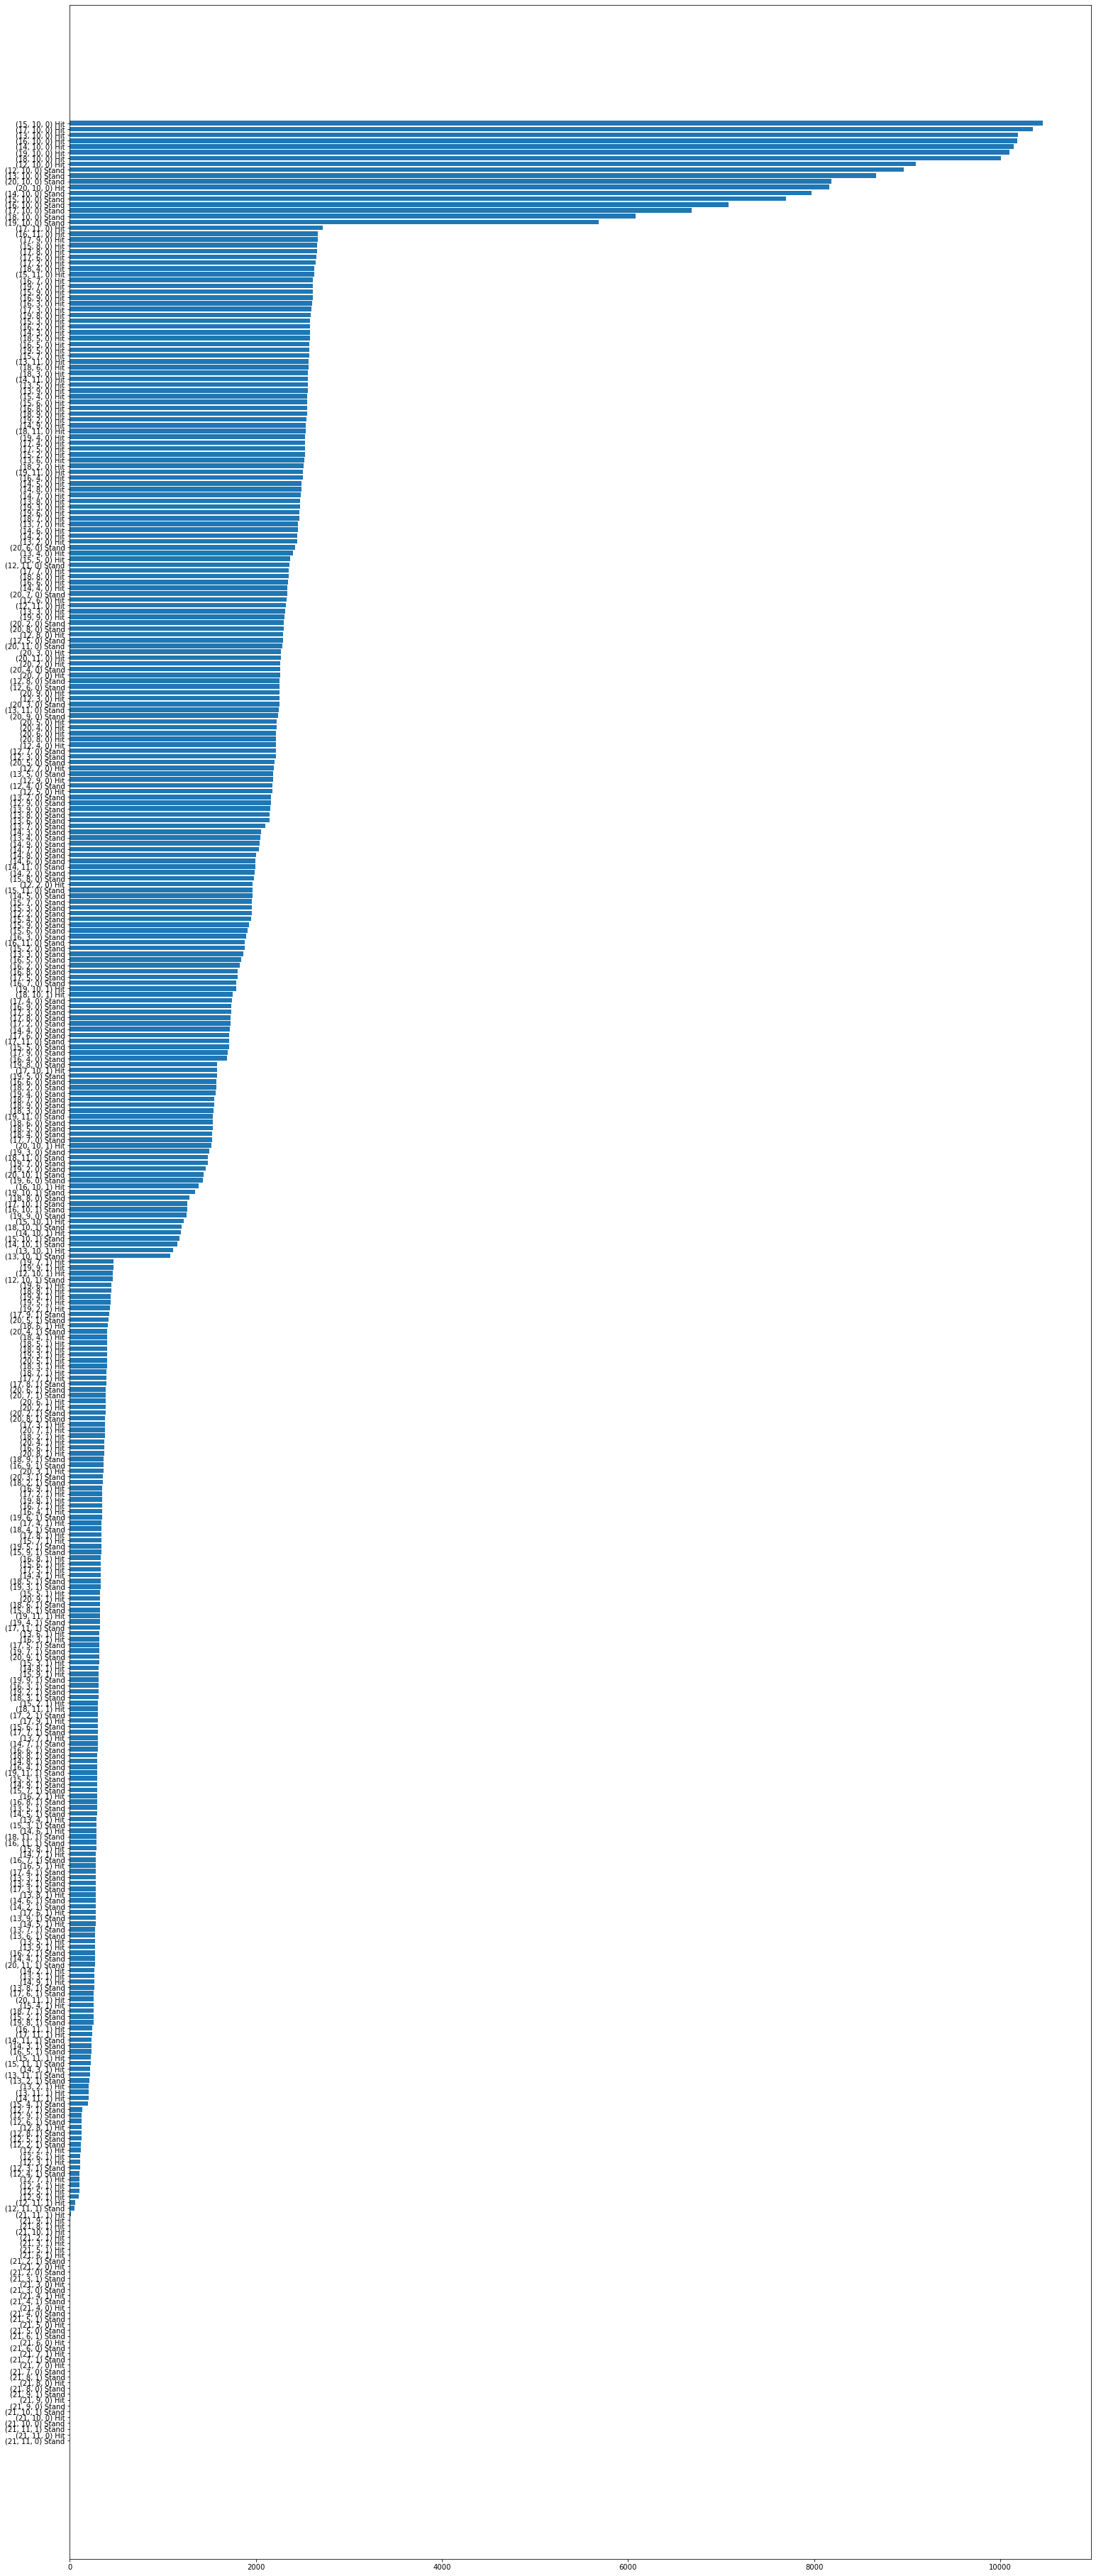

In [25]:
states = list()
action = list()
for k,v in SACounter.items():
    states.append(k)
    states.append(k)
    action.append(v[0])
    action.append(v[1])
for names in range(len(states)):
    if names % 2 == 0:
        states[names] = str(states[names]) + ' Hit'
    else: 
        states[names] = str(states[names]) + ' Stand'
length = len(states)
statesNew = list()
actionNew = list()
for x in range(length):
    indexpop = action.index(max(action))
    statesNew.append(states.pop(indexpop))
    actionNew.append(action.pop(indexpop))
fig = figure(figsize=(20,50))
print(statesNew)
print(actionNew)
statesNew.reverse()
actionNew.reverse()
print(len(actionNew))
ax = fig.add_axes([0,0,1,1])
# ax2 = fig.add_axes([0,0,1,1])
ax.barh(statesNew, actionNew)
# ax2.barh(statesNew[length//6:], actionNew[length//6:])
plt.show()

Wins:  0  Losses:  0  Draws:  0
Wins:  328  Losses:  639  Draws:  33
Wins:  341  Losses:  614  Draws:  45
Wins:  332  Losses:  614  Draws:  54
Wins:  341  Losses:  618  Draws:  41
Wins:  347  Losses:  608  Draws:  45
Wins:  334  Losses:  614  Draws:  52
Wins:  332  Losses:  620  Draws:  48
Wins:  308  Losses:  642  Draws:  50
Wins:  308  Losses:  663  Draws:  29
Wins:  330  Losses:  624  Draws:  46
Wins:  333  Losses:  628  Draws:  39
Wins:  331  Losses:  628  Draws:  41
Wins:  359  Losses:  599  Draws:  42
Wins:  373  Losses:  599  Draws:  28
Wins:  319  Losses:  629  Draws:  52
Wins:  335  Losses:  620  Draws:  45
Wins:  320  Losses:  631  Draws:  49
Wins:  343  Losses:  609  Draws:  48
Wins:  313  Losses:  643  Draws:  44
Wins:  340  Losses:  618  Draws:  42
Wins:  306  Losses:  649  Draws:  45
Wins:  362  Losses:  583  Draws:  55
Wins:  342  Losses:  607  Draws:  51
Wins:  352  Losses:  611  Draws:  37
Wins:  339  Losses:  604  Draws:  57
Wins:  344  Losses:  618  Draws:  38
Wins: 

Wins:  294  Losses:  655  Draws:  51
Wins:  309  Losses:  654  Draws:  37
Wins:  344  Losses:  610  Draws:  46
Wins:  328  Losses:  632  Draws:  40
Wins:  328  Losses:  619  Draws:  53
Wins:  350  Losses:  616  Draws:  34
Wins:  312  Losses:  639  Draws:  49
Wins:  313  Losses:  632  Draws:  55
Wins:  320  Losses:  637  Draws:  43
Wins:  331  Losses:  620  Draws:  49
Wins:  299  Losses:  664  Draws:  37
Wins:  337  Losses:  616  Draws:  47
Wins:  331  Losses:  621  Draws:  48
Wins:  342  Losses:  611  Draws:  47
Wins:  335  Losses:  626  Draws:  39
Wins:  358  Losses:  598  Draws:  44
Wins:  337  Losses:  618  Draws:  45
Wins:  351  Losses:  611  Draws:  38
Wins:  335  Losses:  612  Draws:  53
Wins:  323  Losses:  630  Draws:  47
Wins:  348  Losses:  597  Draws:  55
Wins:  338  Losses:  611  Draws:  51
Wins:  336  Losses:  621  Draws:  43
Wins:  327  Losses:  630  Draws:  43
Wins:  354  Losses:  603  Draws:  43
Wins:  348  Losses:  616  Draws:  36
Wins:  343  Losses:  616  Draws:  41
W

Wins:  337  Losses:  615  Draws:  48
Wins:  335  Losses:  616  Draws:  49
Wins:  352  Losses:  608  Draws:  40
Wins:  324  Losses:  627  Draws:  49
Wins:  323  Losses:  617  Draws:  60
Wins:  333  Losses:  619  Draws:  48
Wins:  340  Losses:  606  Draws:  54
Wins:  320  Losses:  629  Draws:  51
Wins:  328  Losses:  626  Draws:  46
Wins:  356  Losses:  595  Draws:  49
Wins:  318  Losses:  631  Draws:  51
Wins:  341  Losses:  620  Draws:  39
Wins:  362  Losses:  583  Draws:  55
Wins:  316  Losses:  627  Draws:  57
Wins:  306  Losses:  659  Draws:  35
Wins:  315  Losses:  631  Draws:  54
Wins:  303  Losses:  642  Draws:  55
Wins:  311  Losses:  644  Draws:  45
Wins:  341  Losses:  624  Draws:  35
Wins:  327  Losses:  622  Draws:  51
Wins:  337  Losses:  622  Draws:  41
Wins:  341  Losses:  624  Draws:  35
Wins:  327  Losses:  616  Draws:  57
Wins:  346  Losses:  610  Draws:  44
Wins:  322  Losses:  631  Draws:  47
Wins:  325  Losses:  621  Draws:  54
Wins:  359  Losses:  602  Draws:  39
W

Wins:  423  Losses:  522  Draws:  55
Wins:  436  Losses:  510  Draws:  54
Wins:  439  Losses:  500  Draws:  61
Wins:  421  Losses:  512  Draws:  67
Wins:  429  Losses:  513  Draws:  58
Wins:  399  Losses:  543  Draws:  58
Wins:  414  Losses:  536  Draws:  50
Wins:  401  Losses:  537  Draws:  62
Wins:  441  Losses:  514  Draws:  45
Wins:  427  Losses:  511  Draws:  62
Wins:  409  Losses:  542  Draws:  49
Wins:  422  Losses:  514  Draws:  64
Wins:  422  Losses:  512  Draws:  66
Wins:  435  Losses:  497  Draws:  68
Wins:  385  Losses:  538  Draws:  77
Wins:  434  Losses:  507  Draws:  59
Wins:  402  Losses:  536  Draws:  62
Wins:  425  Losses:  514  Draws:  61
Wins:  436  Losses:  501  Draws:  63
Wins:  391  Losses:  541  Draws:  68
Wins:  386  Losses:  540  Draws:  74
Wins:  421  Losses:  523  Draws:  56
Wins:  452  Losses:  490  Draws:  58
Wins:  446  Losses:  495  Draws:  59
Wins:  399  Losses:  541  Draws:  60
Wins:  422  Losses:  521  Draws:  57
Wins:  435  Losses:  517  Draws:  48
W

Wins:  428  Losses:  501  Draws:  71
Wins:  422  Losses:  522  Draws:  56
Wins:  409  Losses:  531  Draws:  60
Wins:  423  Losses:  531  Draws:  46
Wins:  413  Losses:  528  Draws:  59
Wins:  418  Losses:  519  Draws:  63
Wins:  425  Losses:  532  Draws:  43
Wins:  425  Losses:  525  Draws:  50
Wins:  424  Losses:  518  Draws:  58
Wins:  431  Losses:  510  Draws:  59
Wins:  438  Losses:  496  Draws:  66
Wins:  402  Losses:  519  Draws:  79
Wins:  402  Losses:  524  Draws:  74
Wins:  427  Losses:  510  Draws:  63
Wins:  405  Losses:  535  Draws:  60
Wins:  435  Losses:  502  Draws:  63
Wins:  441  Losses:  499  Draws:  60
Wins:  427  Losses:  516  Draws:  57
Wins:  442  Losses:  504  Draws:  54
Wins:  451  Losses:  501  Draws:  48
Wins:  406  Losses:  543  Draws:  51
Wins:  423  Losses:  522  Draws:  55
Wins:  404  Losses:  544  Draws:  52
Wins:  417  Losses:  525  Draws:  58
Wins:  423  Losses:  513  Draws:  64
Wins:  412  Losses:  533  Draws:  55
Wins:  436  Losses:  517  Draws:  47
W

Wins:  417  Losses:  519  Draws:  64
Wins:  411  Losses:  520  Draws:  69
Wins:  430  Losses:  521  Draws:  49
Wins:  464  Losses:  477  Draws:  59
Wins:  395  Losses:  546  Draws:  59
Wins:  428  Losses:  528  Draws:  44
Wins:  414  Losses:  529  Draws:  57
Wins:  419  Losses:  519  Draws:  62
Wins:  422  Losses:  524  Draws:  54
Wins:  437  Losses:  524  Draws:  39
Wins:  446  Losses:  497  Draws:  57
Wins:  427  Losses:  518  Draws:  55
Wins:  404  Losses:  535  Draws:  61
Wins:  418  Losses:  524  Draws:  58
Wins:  428  Losses:  518  Draws:  54
Wins:  419  Losses:  531  Draws:  50
Wins:  418  Losses:  523  Draws:  59
Wins:  435  Losses:  504  Draws:  61
Wins:  400  Losses:  553  Draws:  47
Wins:  449  Losses:  501  Draws:  50
Wins:  416  Losses:  527  Draws:  57
Wins:  425  Losses:  511  Draws:  64
Wins:  446  Losses:  492  Draws:  62
Wins:  424  Losses:  514  Draws:  62
Wins:  439  Losses:  496  Draws:  65
Wins:  430  Losses:  518  Draws:  52
Wins:  425  Losses:  519  Draws:  56
W

Wins:  407  Losses:  531  Draws:  62
Wins:  431  Losses:  519  Draws:  50
Wins:  413  Losses:  535  Draws:  52
Wins:  417  Losses:  536  Draws:  47
Wins:  421  Losses:  517  Draws:  62
Wins:  445  Losses:  489  Draws:  66
Wins:  420  Losses:  509  Draws:  71
Wins:  386  Losses:  550  Draws:  64
Wins:  418  Losses:  521  Draws:  61
Wins:  419  Losses:  511  Draws:  70
Wins:  452  Losses:  486  Draws:  62
Wins:  421  Losses:  524  Draws:  55
Wins:  411  Losses:  519  Draws:  70
Wins:  432  Losses:  522  Draws:  46
Wins:  461  Losses:  483  Draws:  56
Wins:  445  Losses:  494  Draws:  61
Wins:  407  Losses:  538  Draws:  55
Wins:  408  Losses:  527  Draws:  65
Wins:  421  Losses:  531  Draws:  48
Wins:  418  Losses:  513  Draws:  69
Wins:  451  Losses:  495  Draws:  54
Wins:  410  Losses:  533  Draws:  57
Wins:  404  Losses:  547  Draws:  49
Wins:  467  Losses:  476  Draws:  57
Wins:  427  Losses:  528  Draws:  45
Wins:  400  Losses:  539  Draws:  61
Wins:  430  Losses:  513  Draws:  57
W

Wins:  424  Losses:  530  Draws:  46
Wins:  394  Losses:  544  Draws:  62
Wins:  452  Losses:  501  Draws:  47
Wins:  433  Losses:  508  Draws:  59
Wins:  413  Losses:  520  Draws:  67
Wins:  423  Losses:  526  Draws:  51
Wins:  407  Losses:  529  Draws:  64
Wins:  417  Losses:  528  Draws:  55
Wins:  429  Losses:  513  Draws:  58
Wins:  413  Losses:  520  Draws:  67
Wins:  412  Losses:  532  Draws:  56
Wins:  416  Losses:  521  Draws:  63
Wins:  405  Losses:  538  Draws:  57
Wins:  388  Losses:  555  Draws:  57
Wins:  414  Losses:  523  Draws:  63
Wins:  380  Losses:  551  Draws:  69
Wins:  418  Losses:  519  Draws:  63
Wins:  424  Losses:  510  Draws:  66
Wins:  392  Losses:  560  Draws:  48
Wins:  401  Losses:  550  Draws:  49
Wins:  451  Losses:  503  Draws:  46
Wins:  427  Losses:  506  Draws:  67
Wins:  410  Losses:  534  Draws:  56
Wins:  422  Losses:  517  Draws:  61
Wins:  441  Losses:  505  Draws:  54
Wins:  411  Losses:  534  Draws:  55
Wins:  412  Losses:  527  Draws:  61
W

Wins:  416  Losses:  522  Draws:  62
Wins:  426  Losses:  502  Draws:  72
Wins:  413  Losses:  524  Draws:  63
Wins:  439  Losses:  503  Draws:  58
Wins:  416  Losses:  529  Draws:  55
Wins:  429  Losses:  518  Draws:  53
Wins:  412  Losses:  533  Draws:  55
Wins:  430  Losses:  508  Draws:  62
Wins:  401  Losses:  547  Draws:  52
Wins:  425  Losses:  519  Draws:  56
Wins:  425  Losses:  521  Draws:  54
Wins:  430  Losses:  517  Draws:  53
Wins:  426  Losses:  507  Draws:  67
Wins:  425  Losses:  539  Draws:  36
Wins:  413  Losses:  534  Draws:  53
Wins:  428  Losses:  507  Draws:  65
Wins:  406  Losses:  528  Draws:  66
Wins:  433  Losses:  507  Draws:  60
Wins:  406  Losses:  527  Draws:  67
Wins:  423  Losses:  522  Draws:  55
Wins:  451  Losses:  485  Draws:  64
Wins:  435  Losses:  504  Draws:  61
Wins:  424  Losses:  513  Draws:  63
Wins:  432  Losses:  509  Draws:  59
Wins:  446  Losses:  509  Draws:  45
Wins:  420  Losses:  526  Draws:  54
Wins:  432  Losses:  514  Draws:  54
W

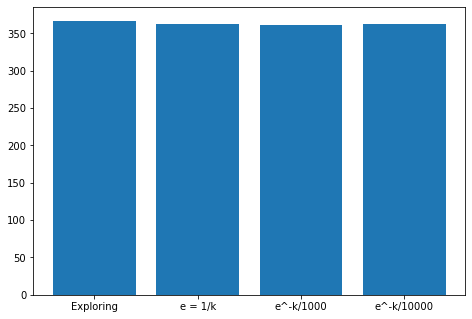

[367, 363, 361, 363]


In [16]:
EA, WA, LA, DA ,SACounterA,T = game(1,ep)
EB, WB, LB, DB, SACounterB,T = game(2,ep)
EC, WC, LC, DC, SACounterC,T = game(3,ep) 
ED, WD, LD, DD, SACounterD,T = game(4,ep) 
allCounters = [SACounterA, SACounterB, SACounterC, SACounterD]
newCounter = list()
for allc in allCounters:
    holdVal = list()
    for k,v in allc.items():
        if v[0] != 0:
            holdVal.append(v[0])
        if v[1] != 0:
            holdVal.append(v[1])
    newCounter.append(len(holdVal))

policy = ["Exploring", "e = 1/k", "e^-k/1000", "e^-k/10000"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])            
       
ax.bar(policy,newCounter)
plt.show()     
print(newCounter)

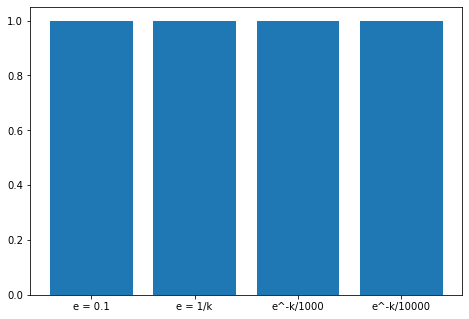

In [17]:
WA = WA[400:500]
WB = WB[400:500]
WC = WC[400:500]
WD = WD[400:500]
LA = LA[400:500]
LB = LB[400:500]
LC = LC[400:500]
LD = LD[400:500]
totalWA = 0
totalWB = 0
totalWC = 0
totalWD = 0
totalLA = 0
totalLB = 0
totalLC = 0
totalLD = 0

for x in range(len(WA)):
    totalWA += WA[x]
    totalWB += WB[x]
    totalWC += WC[x]
    totalWD += WD[x]
    totalLA += LA[x]
    totalLB += LB[x]
    totalLC += LC[x]
    totalLD += LD[x]
    
totalWA /= 100
totalWB /= 100
totalWC /= 100
totalWD /= 100
totalLA /= 100
totalLB /= 100
totalLC /= 100
totalLD /= 100

totalWA = ((totalLA-totalWA)/(totalLA-totalWA))
totalWB = ((totalLB-totalWB)/(totalLB-totalWB))
totalWC = ((totalLC-totalWC)/(totalLC-totalWC))
totalWD = ((totalLD-totalWD)/(totalLD-totalWD))

policy = ["e = 0.1", "e = 1/k", "e^-k/1000", "e^-k/10000"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])            
    
advantage = [totalWA,totalWB,totalWC,totalWD]

ax.bar(policy,advantage)
plt.show()     
